# Get Started With Sentiment Analysis Using TensorFlow Keras

References:

https://www.tensorflow.org/datasets/catalog/imdb_reviews

https://www.tensorflow.org/text/tutorials/text_classification_rnn


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
import matplotlib.pyplot as plt

# IMDB Dataset

In [2]:
data, meta = tfds.load('imdb_reviews/subwords8k',
                      with_info = True,
                      as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL9QVVU/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL9QVVU/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteL9QVVU/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
data.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [4]:
train = data['train']
test = data['test']
train, test

(<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>)

In [5]:
# explore the features in metadata
meta.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [6]:
# extract the encoder
encoder = meta.features['text'].encoder

In [7]:
encoder.vocab_size

8185

In [8]:
print(encoder.subwords[:100])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing']


In [9]:
example = 'Analytics India Magazine !'
enc = encoder.encode(example)
enc

[1291, 375, 8050, 1540, 8, 6552, 4, 2853, 7908, 442, 5219]

In [10]:
for integer in enc:
    text = encoder.decode([integer])
    print('%4d : %s'%(integer, text))

1291 : An
 375 : al
8050 : y
1540 : tic
   8 : s 
6552 : Indi
   4 : a 
2853 : Mag
7908 : azi
 442 : ne
5219 :  !


In [11]:
it = iter(train)

In [12]:
next(it)[0].numpy().shape, next(it)[1].numpy().shape

((163,), ())

In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_data = train.shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))
train_data = train_data.prefetch(AUTOTUNE)

test_data = test.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

In [14]:
embed_layer = keras.layers.Embedding(encoder.vocab_size, 64)

# Build Model

In [15]:
model = keras.Sequential([
    # embedding layer
    embed_layer,
    # bidirectional LSTM layers
    Bidirectional(LSTM(64, 
                       dropout=0.5, 
                       recurrent_dropout=0.5, 
                       return_sequences=True)),
    Bidirectional(LSTM(32, 
                       dropout=0.5, 
                       recurrent_dropout=0.5, 
                       return_sequences=True)),
    Bidirectional(LSTM(16, 
                       dropout=0.5, 
                       recurrent_dropout=0.5)),
    # Classification head
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')    
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

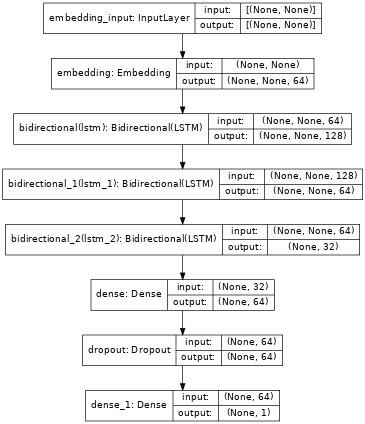

In [21]:
keras.utils.plot_model(model, show_shapes=True, dpi=48)

# Train the Model

In [19]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [20]:
history = model.fit(train_data, 
                    validation_data=test_data, 
                    epochs=2)

Epoch 1/2
391/391 [==============================] - 12933s 33s/step - loss: 0.8839 - accuracy: 0.5076 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 2/2
391/391 [==============================] - 12908s 33s/step - loss: 0.6941 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5000


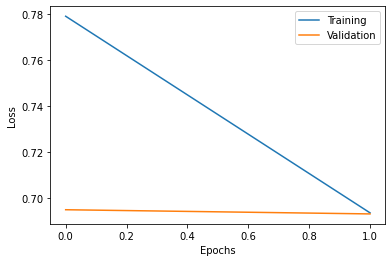

In [22]:
hist = history.history

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(labels=['Training', 'Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [23]:
# Sample prediction

samples = ['The plot is fantastic', 
           'The movie was cool and thrilling', 
           'one of the worst films I have ever seen']

# encode into integers
sample_encoded = [encoder.encode(sample) for sample in samples]

# pad with zeros to have same length 
sample_padded = []
for s in sample_encoded:
    pad_length = 128 - len(s)
    zeros = [0]*pad_length
    s.extend(zeros)
    s = tf.convert_to_tensor(s)
    sample_padded.append(s)
    
# convert into tensor before feeding the model
sample_padded = tf.convert_to_tensor(sample_padded)
#make predictions
predictions = model.predict(sample_padded)
predictions

array([[0.90058655],
       [0.791466  ],
       [0.2801157 ]], dtype=float32)

In [29]:
print('Predictions on sample test reviews... \n')
for i in range(len(samples)):
    pred = predictions[i][0]
    sentiment = 'positive' if pred>0.5 else 'negative'
    print('%40s : %s'%(samples[i], sentiment))

Predictions on sample test reviews... 

                   The plot is fantastic : positive
        The movie was cool and thrilling : positive
 one of the worst films I have ever seen : negative


https://github.com/RajkumarGalaxy/NLP/blob/master/get-started-with-sentiment-analysis-tf-keras.ipynb


### Thank You For Your Time!